# 1 -  Planejamento da Solução

## Entendimento de Negócio

**Qual é o problema de negócio?**

- Empresa alimentícia situada no RJ, deseja abrir filiais na cidade de São Paulo. Para isso, precisa de 3 análises:
    - 1 - Estimar faturamento que uma loja teria em cada um dos bairros de São Paulo (regressão, neste caso sem séries temporais).
    - 2 - Classificar o potencial dos bairros de São Paulo em alto, médio ou baixo (classificação multiclasse).
    - 3 - Segmentar os bairros de São Paulo de acordo com o perfil de renda e idade, identificando os com maior aderência ao público alvo.
    
- Público alvo: adultos de 25 a 50 anos, das classes A (rendas A1 e A2) e B (rendas B1 e B2). 

**Saída**

- Prototipagem técnica da solução: https://docs.google.com/spreadsheets/d/17lxCBRLPEuNCO25BimVFRE3Tms-314WSTpJ1xgEIf38/edit#gid=0

- O que será entregue, efetivamente? / Onde o time de negócio quer ver?
    - Documento no formato doc, pdf ou ppt, voltado ao negócio, apresentando um racional de como os dados foram analisados. Detalhar com gráficos, tabelas, e descrever conclusões.
    - Responder: Dada a natureza do problema apresentado, que outro dado externo (fontes públicas ou privadas) poderia ser utilizado para agregar mais valor ao resultado? Por que?
    
**Entrada**
- Fontes de dados:
    - Dataset contendo faturamento e potencial dos bairros do Rio de Janeiro do cliente, bem como dados sociodemográficos do bairros do Rio de Janeiro e São Paulo.

- Ferramentas:
    - Python 3.8.12, Jupyter Notebook, Git, Github.

**Processamento**
- Tipo de problema: análise exploratória, regressão, classificação e clusterização.
- Metodologia: CRISP-DM, metodologia ágil (iterativa e incremental) para desenvolvimento de projetos de ciência de dados.


## Implementado nesta Sprint

**Ciclo 1**
- Entendimento do problema de negócio e planejamento da solução.
- Coleta de dados.
- Limpeza e análise preliminar.
- Separação entre RJ e SP.
- Implementação de modelos de base de machine learning para as análises 1 e 2.
- Implementação de modelo de clusterização para a análise 3, e criação de perfis dos clusters.

# 2 - Importações

## Bibliotecas

In [1]:
import pandas                      as pd 
import seaborn                     as sns
import numpy                       as np
import inflection
from IPython.core.display          import HTML
from matplotlib                    import pyplot as plt
from tabulate                      import tabulate

from sklearn.model_selection       import train_test_split
from sklearn.neighbors             import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster               import KMeans
from yellowbrick.cluster           import KElbowVisualizer
from sklearn.metrics               import silhouette_score, r2_score, accuracy_score

## Funções Auxiliares

In [2]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizando tamanhos de plots, etc """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

## Coleta de Dados

Carregamento dos dados originais do xlsx.

In [26]:
df_raw = pd.read_excel("../data/raw/data_raw.xlsx")
print(df_raw.shape)
df_raw.head(3)

(456, 24)


,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200.0,Baixo


# 3 - Limpeza e Análise Preliminar

## Renomear Colunas

Padroinzar nome das variáveis no formato snake_case, melhorando sua legibilidade.

In [4]:
cols_old = ['codigo', 'bairro', 'cidade', 'estado', 'populacao', 'popAte9',
       'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
       'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2',
       'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2',
       'domiciliosD', 'domiciliosE', 'rendaMedia', 'faturamento', 'potencial']
snakecase = lambda x: inflection.underscore ( x )
cols_new = list( map( snakecase, cols_old ) )
df_raw.columns = cols_new
df_raw.columns

Index(['codigo', 'bairro', 'cidade', 'estado', 'populacao', 'pop_ate9',
       'pop_de10a14', 'pop_de15a19', 'pop_de20a24', 'pop_de25a34',
       'pop_de35a49', 'pop_de50a59', 'pop_mais_de60', 'domicilios_a1',
       'domicilios_a2', 'domicilios_b1', 'domicilios_b2', 'domicilios_c1',
       'domicilios_c2', 'domicilios_d', 'domicilios_e', 'renda_media',
       'faturamento', 'potencial'],
      dtype='object')

## Dicionário de Dados

Compreender com clareza o significado de cada variável é fundamental para avançar no projeto.

In [6]:
tab = [['Coluna', 'Significado'],   
       ['codigo', 'Código do bairro'],
       ['bairro', 'Nome do bairro'],
       ['cidade', 'Cidade'],
       ['estado', 'Estado'],
       ['populacao', 'População total'],
       ['pop_ate9', 'População - até 9 anos'],
       ['pop_de10a14', 'População - de 10 a 14 anos'],
       ['pop_de15a19', 'População - de 15 a 19 anos'],
       ['pop_de20a24', 'População - de 20 a 24 anos'],
       ['pop_de25a34', 'População - de 25 a 34 anos'],
       ['pop_de35a49', 'População - de 35 a 49 anos'],
       ['pop_de50a59', 'População - de 50 a 59 anos'],
       ['pop_mais_de60', 'População - 60 anos ou mais'],
       ['domicilios_a1', 'Quantidade de Domicílios de Renda A1'],
       ['domicilios_a2', 'Quantidade de Domicílios de Renda A2'],
       ['domicilios_b1', 'Quantidade de Domicílios de Renda B1'],
       ['domicilios_b2', 'Quantidade de Domicílios de Renda B2'],
       ['domicilios_c1', 'Quantidade de Domicílios de Renda C1'],
       ['domicilios_c2', 'Quantidade de Domicílios de Renda C2'],
       ['domicilios_d', 'Quantidade de Domicílios de Renda D'],
       ['domicilios_e', 'Quantidade de Domicílios de Renda E'],
       ['renda_media', 'Renda Média por Domicílio'],
       ['faturamento', 'Faturamento Total no Bairro'],
       ['potencial', 'Potencial do Bairro']]
print(tabulate(tab, headers='firstrow', stralign='left')) #tablefmt='pipe', tablefmt='grid'

Coluna         Significado
-------------  ------------------------------------
codigo         Código do bairro
bairro         Nome do bairro
cidade         Cidade
estado         Estado
populacao      População total
pop_ate9       População - até 9 anos
pop_de10a14    População - de 10 a 14 anos
pop_de15a19    População - de 15 a 19 anos
pop_de20a24    População - de 20 a 24 anos
pop_de25a34    População - de 25 a 34 anos
pop_de35a49    População - de 35 a 49 anos
pop_de50a59    População - de 50 a 59 anos
pop_mais_de60  População - 60 anos ou mais
domicilios_a1  Quantidade de Domicílios de Renda A1
domicilios_a2  Quantidade de Domicílios de Renda A2
domicilios_b1  Quantidade de Domicílios de Renda B1
domicilios_b2  Quantidade de Domicílios de Renda B2
domicilios_c1  Quantidade de Domicílios de Renda C1
domicilios_c2  Quantidade de Domicílios de Renda C2
domicilios_d   Quantidade de Domicílios de Renda D
domicilios_e   Quantidade de Domicílios de Renda E
renda_media    Renda Média por 

## Tipos de Dados

Avaliar tipos de dados, e necessidade de conversões.

In [8]:
df_raw.dtypes

codigo             int64
bairro            object
cidade            object
estado            object
populacao          int64
pop_ate9           int64
pop_de10a14        int64
pop_de15a19        int64
pop_de20a24        int64
pop_de25a34        int64
pop_de35a49        int64
pop_de50a59        int64
pop_mais_de60      int64
domicilios_a1      int64
domicilios_a2      int64
domicilios_b1      int64
domicilios_b2      int64
domicilios_c1      int64
domicilios_c2      int64
domicilios_d       int64
domicilios_e       int64
renda_media       object
faturamento      float64
potencial         object
dtype: object

No momento, não é possível converter "faturamento" para o tipo "int", em função dos dados de SP, onde há registros nulos.

A conversão se justifica porque esta variável não utiliza as casas decimais (sempre zeradas).

Farei esta conversão mais abaixo, após a separação entre os dados de RJ e SP.

Demais variáveis estão ok.

## Conferência de Nulos

Avaliação de tratativa de registros nulos.

In [8]:
df_raw.isna().sum()

codigo             0
bairro             0
cidade             0
estado             0
populacao          0
pop_ate9           0
pop_de10a14        0
pop_de15a19        0
pop_de20a24        0
pop_de25a34        0
pop_de35a49        0
pop_de50a59        0
pop_mais_de60      0
domicilios_a1      0
domicilios_a2      0
domicilios_b1      0
domicilios_b2      0
domicilios_c1      0
domicilios_c2      0
domicilios_d       0
domicilios_e       0
renda_media        6
faturamento      296
potencial        296
dtype: int64

Confirmar se os registros com valores nulos em "faturamento" e "potencial" são de fato apenas os registros de SP.

In [10]:
df_raw.loc[(df_raw.potencial.isna() == True) & (df_raw.faturamento.isna() == True) & (df_raw.estado == "SP")].shape

(296, 24)

Confirmado. Dado que "faturamento" e "potencial" são as variáveis alvo, e iremos prever estes valores nulos. 

Logo, não há necessidade de tratativas.

## Separação entre RJ e SP

Separação do dataset em duas pares, sendo:
- df_rj: registros onde estado = RJ, contendo valores nas variáveis alvo "faturamento" e "potencial".
    - Utilizados para treinar, validar e confirmar aprendizado dos algoritmos supervisionados (análises 1 e 2). 
    - Também utilizados para treinar e avaliar os algoritmos não supervisionados (análise 3). 
- df_sp: registros onde estado = SP, contendo valores nulos para as variáveis alvo.
    - Utilizados apenas na versão final do modelo de cada uma das 3 análises, se tratando dos registros dos bairros de SP. 

In [12]:
df_rj = df_raw.loc[df_raw["estado"] == "RJ"].copy()
df_sp = df_raw.loc[df_raw["estado"] == "SP"].copy()

print (f"Número de linhas e colunas de df_rj: {df_rj.shape}")
print (f"Número de linhas e colunas de df_sp: {df_sp.shape}")

Número de linhas e colunas de df_rj: (160, 24)
Número de linhas e colunas de df_sp: (296, 24)


Converter "faturamento" de df_rj para o tipo int, visto que não utiliza as casas decimais, conforme já citado anteriormente.

In [13]:
df_rj["faturamento"] = df_rj["faturamento"].astype(int)
df_rj.head(1)

,codigo,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515,Médio


Exportar os dois datasets gerados para o formato .csv.

In [14]:
df_rj.to_csv('../data/interim/df_rj.csv')
df_sp.to_csv('../data/interim/df_sp.csv')

## Estatística Descritiva

Realizada em cimda com 2 propósitos:
- Obter maior conhecimento de negócio a partir do comportamento dos dados.
- Detectar eventuais erros e sanar dúvidas sobre os dados, como faturamento negativo, por exemplo.

PS: Será realizada no ciclo 2.

# 4 - Análise 1: Estimativa de faturamento em SP

Análise 1 - Estimar o faturamento que uma loja teria em cada um dos bairros de São Paulo (regressão).

## Divisão dos Dados

Trata-se portanto de um problema de regressão (supervisionado), sendo a variável alvo "faturamento" do tipo float (contínua).

df_rj será dividida em três partes, sendo:
- Dados de treinamento (train): utilizados para treinar os modelos de machine learning.
- Dados de validação (val): utilizados para validar a performance dos modelos, e para tunagem de hiperparâmetros.
- Dados de teste (test): utilizados para avaliação final da capacidade de generalização dos modelos, simulando dados de produção (registros de SP).

Divisão entre features e variável alvo:

In [27]:
y1 = df_rj.faturamento
y1.head(2)

0    932515
1    588833
Name: faturamento, dtype: int64

A variável "codigo" não é informativa, logo será descartada.

In [28]:
X1 = df_rj.drop(["codigo","faturamento"], axis=1)
X1.head(1)

,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,potencial
0,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,Médio


Divisão entre datasets de treino e teste, mantendo 15% dos registros para teste.

O parâmetro "random_state" é utilizado para manter a reprodutibilidade da divisão.

In [29]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0, test_size=0.15)

In [30]:
print(X1_train.shape)
print(X1_test.shape)
X1_train.head(1)

(136, 22)
(24, 22)


,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,potencial
37,Cordovil,Rio de Janeiro,RJ,46478,5729,2893,3768,3850,7146,9369,5598,8125,0,0,1047,2433,4599,4053,723,2601,1480,Médio


Divisão entre datasets de treino e validação (a partir do treino), mantendo 15% dos registros para validação.

In [31]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, random_state=0, test_size=0.15)

In [32]:
print(X1_train.shape)
print(X1_val.shape)
X1_train.head(1)

(115, 22)
(21, 22)


,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,potencial
63,Higienópolis,Rio de Janeiro,RJ,16177,1516,748,1016,1174,2488,3497,2327,3411,0,141,857,1464,1740,1030,87,432,2336,Médio


## Implementação de Baseline

Como algoritmo de machine learning de base, será implementado o KNN Regressor (K-Nearest Neighbors, ou "K vizinhos mais próximos") da biblioteca scikit-learn.
- É um bom baseline por ser simples de implementar, explicar ao time de negócio, e demandar pouca parametrização.

Funcionamento:
- O KNN não constrói um modelo (é chamado de “lazy”), mas armazena o dataset de treino dentro dele.
- Para prever um novo ponto sem rótulo, encontra o ponto mais próximo dele com rótulo armazenado, sendo seu "nearest neighbor".

Premissas:
- Receber apenas features numéricas, e na mesma escala (demanda pré processamento), pois realiza cálculos de distâncias entre os pontos.

Manter apenas features numéricas, respeitando a premissa do KNN.

In [33]:
X1_train = X1_train.select_dtypes(include=['int64', 'float64'])
X1_val = X1_val.select_dtypes(include=['int64', 'float64'])
X1_train.head(1)

,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e
63,16177,1516,748,1016,1174,2488,3497,2327,3411,0,141,857,1464,1740,1030,87,432


Instanciar um KNN Regressor, treinar com os dados de treino, e realizar predições com os dados de validação.

Será parametrizado neste ciclo um número de k=3, visando um modelo mais simples que o K=5 default, com a expectativa de uma maior capacidade de generalização. Nos próximos ciclos, serão avaliados diferentes valores de K, para comparação.  

In [34]:
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(X1_train, y1_train)
knn_reg_yhat = knn_reg.predict(X1_val)

A métrica utilizada para medir a performance do modelo será a R squared (ou coeficiente de determinação).
- Trata-se de uma medita estatística de quão próximos os dados estão da linha de regressão ajustada.
- Varia entre entre 0 e 100%, sendo a porcentagem da variação da variável resposta que é explicada por um modelo linear.
- Busca-se portanto, o valor mais próximo de 100% possível, sendo aqui a previsão de faturamento mais próxima da realidade possível.

In [35]:
print("R^2 com dados de Validação {:.4f}".format(knn_reg.score(X1_val, y1_val)))

R^2 com dados de Validação 0.5709


Pode-se calcular também o R^2 a partir da predição do modelo, através do pacote "metrics" do scikit-sklearn.

In [36]:
print(f"R^2 com dados de Validação: {round(r2_score(y1_val, knn_reg_yhat),4)}")

R^2 com dados de Validação: 0.5709


O R Squared do KNN foi satisfatório neste primeiro ciclo. Possivlmente a métrica pode ser melhorada, por meio de:
- Reescala de dados.
- Seleção de features, removendo as não informativas e aquelas não relacionadas ao público alvo.
- Seleção de diferentes valores para K, bem como tunagem de hiperparâmetros no modelo.
- Avaliação da presença de outliers, que podem distorcer os cálculos de distâncias.

Nos próximos ciclos, estes temas serão tratados, e novos algoritmos com diferentes abordagens também serão implementados.

No último ciclo, será avaliada a capacidade de generalização do modelo final (de melhor performance), realizando a previsão com os dados de teste.

# 5 - Análise 2: Classificação do potencial em SP

Análise 2 - Classificar o potencial dos bairros de São Paulo em alto, médio ou baixo (classificação multiclasse).

## Divisão dos Dados

Trata-se portanto de um problema de classificação multiclasse (supervisionado), sendo a variável alvo "potencial" categórica. 
- As possíveis categorias de "potencial" são: Alto, Médio e Baixo.

Assim como na análise 1, aqui df_rj também será dividido em três partes: dados de treinamento, validação e teste. 
- A separação dos dados da análise 1 não será aproveitada, porque a variável alvo era "faturamento", e nesta análise será "potencial".
- Ou seja, nesta análise 2, "faturamento" será uma variável preditora (feature), e "potencial" será a variável dependente (target).

Divisão entre features e variável alvo.

In [43]:
y2 = df_rj.potencial
y2.head(2)

0    Médio
1    Baixo
Name: potencial, dtype: object

A variável "codigo" não é informativa, logo será descartada.

In [44]:
X2 = df_rj.drop(["codigo","potencial"], axis=1)
X2.head(1)

,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento
0,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515


Avaliar balanceamento da var resposta.

In [45]:
y2.value_counts(normalize=True)*100

Baixo    38.75
Médio    31.25
Alto     30.00
Name: potencial, dtype: float64

A variável alvo "potencial" está balanceada, ou seja, tem uma distribuição parecida dos registros nas categorias existentes. 
- Isto dispensa tratativas para balanceamento, e permite o uso da métrica de acurácia, para avaliação de performance.

Divisão entre datasets de treino e teste, mantendo 15% dos registros para teste.

- O parâmetro "stratify" é utilizado para manter uma proporção parecida da variável alvo nos dados de treino e de teste.

In [46]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0, test_size=0.15, stratify=y2)

In [47]:
print(X2_train.shape)
print(X2_test.shape)
X2_train.head(1)

(136, 22)
(24, 22)


,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento
4,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020


Divisão entre datasets de treino e validação (a partir dos dados de treino), mantendo 15% dos registros para validação.

In [48]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, random_state=0, test_size=0.15, stratify=y2_train)

In [49]:
print(X2_train.shape)
print(X2_val.shape)
X2_train.head(1)

(115, 22)
(21, 22)


,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento
42,Del Castilho,Rio de Janeiro,RJ,16051,1740,831,1140,1182,2496,3231,2052,3379,0,80,588,1118,1481,1243,166,828,1889,846146


## Implementação de Baseline

Nesta análise, também será implementado o KNN como modelo de base. 

Se tratando de um problema de classificação, será utilizado o KNN classifier da biblioteca scikit-learn.

Manter apenas features numéricas, respeitando a premissa do KNN.

In [50]:
X2_train = X2_train.select_dtypes(include=['int64', 'float64'])
X2_val = X2_val.select_dtypes(include=['int64', 'float64'])
X2_train.head(1)

,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,faturamento
42,16051,1740,831,1140,1182,2496,3231,2052,3379,0,80,588,1118,1481,1243,166,828,846146


Instanciar um KNN Classifier, treinar com os dados de treino, e realizar predições com os dados de validação.

Será parametrizado neste ciclo um número de k=3, visando um modelo mais simples que o K=5 default, com a expectativa de uma maior capacidade de generalização. Nos próximos ciclos, serão avaliados diferentes valores de K, para comparação.

In [51]:
knn_cla = KNeighborsClassifier(n_neighbors=3)
knn_cla.fit(X2_train, y2_train)
knn_cla_yhat = knn_cla.predict(X2_val)

In [52]:
knn_cla_yhat[:3]

array(['Médio', 'Baixo', 'Médio'], dtype=object)

A métrica utilizada para medir a performance do modelo será a acurácia média.
- Varia entre 0 e 100%, e mede quantas predições o modelo acertou, dentre todas as previsões realizadas.
- Busca-se portanto, o valor mais próximo de 100% possível, ou seja, a previsão de potencial mais próxima da realidade possível.

In [53]:
print("Acurácia com dados de Validação: {:.4f}".format(knn_cla.score(X2_val, y2_val)))

Acurácia com dados de Validação: 0.5714


Pode-se calcular também a acurácia média a partir da predição do modelo, através do pacote "metrics" do scikit-sklearn.

In [54]:
print(f"Acurácia com dados de Validação: {round(accuracy_score(y2_val, knn_cla_yhat),4)}")

Acurácia com dados de Validação: 0.5714


A acurácia do KNN foi satisfatória neste primeiro ciclo. Possivlmente a métrica pode ser melhorada, por meio de:
- Reescala de dados.
- Seleção de features, removendo as não informativas e aquelas não relacionadas ao público alvo.
- Seleção de diferentes valores para K, bem como tunagem de hiperparâmetros no modelo.
- Avaliação da presença de outliers, que podem distorcer os cálculos de distâncias.

Nos próximos ciclos, estes temas serão tratados, e novos algoritmos com diferentes abordagens também serão implementados.

No último ciclo, será avaliada a capacidade de generalização do modelo final (de melhor performance), realizando a previsão com os dados de teste.

# 6 - Análise 3: Segmentação por perfil de renda e idade em SP

Análise 3 - Segmentar os bairros de São Paulo de acordo com o perfil de renda e idade, identificando os com maior aderência ao público alvo.

Trata-se portanto de um problema de clusterização (não supervisionado). 

- Nesta tarefa, não há divisão do dataset, sendo passados todos os dados ao modelo, que encontra grupos (clusters) a partir deles.
- Diferentemente das análises anteriores, aqui será utilizado o dataset df_sp, a fim de realizar a segmentação destes bairros.
- Diferentes modelos serão utilizados, sendo neste primeiro ciclo escolhido o K-Means, disponível na biblioteca scikit-learn.

## K-Means

O K-Means (K-médias) possui este nome, porque utiliza centróides, que são o ponto central (médio) do cluster.

Funcionamento: 
- A partir do número de K informado, o K-means criará k centroides aleatoriamente no espaço de dados, que serão os grupos. 
- Serão então calculadas as distâncias de todos os pontos em relação a cada um dos centroides.
- Cada ponto assumirá o rótulo do centroide mais próximo a ele, passando a pertencer a aquele grupo.
- Ao fim do processo, reposiciona-se o centróide no centro do cluster, recalcula-se as distênaicas e atribuição dos pontos aos grupos.
- Quando o centroide convergir e os pontos pararem de ser atribuídos a outro cluster, o agrupamento está concluído.

Características:
- O número de K (grupos) é uma parâmetro.
- Serão gerados sempre clusters convexos, pelo fato de utilizar o raio para calcular as distâncias.
- Assume sempre que os cluster possuem o mesmo diâmetro.
- Como a inicialização dos centróides é aleatória, pode formar grupos distintos conforme a sua posição inicial. Isto pode ser atenuado pelo parâmetro "n_init", que define o número de inicializações aleatórias, e retorna o melhor resultado.
- Necessita que os dados estejam na mesma escala (ou muito próxima), evitando a distorção dos cálculos de distâncias.
- É sensível a outliers, demandando remoção ou tratativa destes.



Clusterizar apenas perfil de renda e idade do público alvo da empresa.

In [55]:
df_sp.head(2)

,codigo,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501,NaN,NaN
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920,NaN,NaN


In [57]:
df_seg = df_sp[["pop_de25a34","pop_de35a49","domicilios_a1","domicilios_a2","domicilios_b2","domicilios_b2"]]
print(df_seg.shape)
df_seg.head(1)

(296, 6)


,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b2,domicilios_b2
160,14535,21549,0,253,4368,4368


Instanciar o KMeans, treinar o modelo, e avaliar sua performance com a biblioteca yellowbrick.
- Serão avaliados cenários de 3 a 6 grupos, pelo entendimento que isto otimiza os esforços do time de negócio em suas ações de marketing direcionado.

In [58]:
clusters = [3, 4, 5, 6]

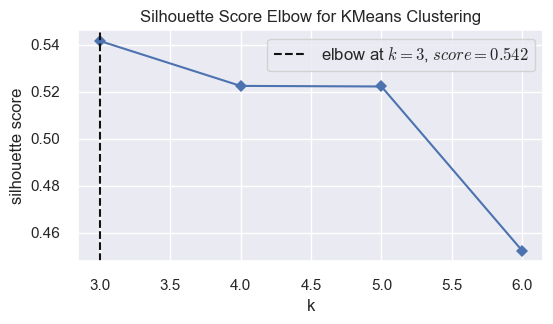

In [65]:
plt.figure(figsize = (6,3));
kmeans_viz = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=clusters, metric='silhouette', timings=False );
kmeans_viz.fit(df_seg);
kmeans_viz.show();

A avaliação dos modelos será dada pela métrica Silhouette Score (SS), que pode ser utilizada para avaliar diferentes clusterizadores.
- A Silhueta (S) é a distância média do ponto em relação aos demais (do mesmo cluster, e de fora dele). A silhuette score é a média de todas as silhuetas de todos os pontos.

A SS mede portanto as duas propriedades que definem uma boa clusterização: 
- A compactação dos clusters (compactness): a distância entre os pontos do mesmo cluster deve ser a menor possível.
- A separação entre os clusters (separation): a distância entre os pontos de clusters diferentes deve ser a maior possível.

Dado que a SS varia entre 0 e 1, quando mais próximo de 1, melhor pode ser considerada a clusterização, considerando as propriedades acima.

A SS do K-Means com k=3 foi levemente superior neste primeiro ciclo. Todavia, pode ser interessante gerar um número maior de grupos de perfil de renda e idade ao time de marketing.

Considerando 4 grupos, foi obtida uma SS maior que 0.5 neste primeiro ciclo, o que é aceitável. Possivlmente a métrica pode ser melhorada, por meio de:
- Reescala de dados.
- Avaliação da presença de outliers, que podem distorcer os cálculos de distâncias.
- Tunagem de hiperparâmetros no modelo.
- Feature engeneering a partir 6 features de perfil de renda e idade do público alvo, buscando melhorar o espaço de dados. 
- Novos algoritmos com diferentes abordagens de clusterização.

Vamos abaixo treinar um K-Means com k=4 para avançar neste ciclo, e salvar suas previsões em uma variávels. 
Nos próximos ciclos, os tópicos acima serão abordados. 



In [66]:
kmeans = KMeans( n_clusters=4, #número de clusters
                  n_init=10, #número de vezes que o k-means irá com diferentes centroid seeds
                 random_state=0) #seed, para gerar a mesma inicialização aleatória
kmeans.fit(df_seg)
labels_kmeans = kmeans.labels_
labels_kmeans[:5]

array([3, 0, 3, 2, 0], dtype=int32)

In [67]:
#this method of k-means (sklearn) returns the SS
print(f"Silhouette Score com k=4: {round(silhouette_score(df_seg, labels_kmeans, metric='euclidean'),2)}") 

Silhouette Score com k=4: 0.52


## K-Means - Perfis dos Clusters

Criar um dataset contendo o grupo de cada bairro pertence. 

In [68]:
df_seg.columns

Index(['pop_de25a34', 'pop_de35a49', 'domicilios_a1', 'domicilios_a2',
       'domicilios_b2', 'domicilios_b2'],
      dtype='object')

In [70]:
df_kmeans = df_sp.copy()
df_kmeans = df_kmeans[['bairro', 'pop_de25a34', 'pop_de35a49', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1', 'domicilios_b2']]
df_kmeans['cluster'] = labels_kmeans
df_kmeans.head(3)

,bairro,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,cluster
160,A. E. Carvalho,14535,21549,0,253,2197,4368,3
161,Aclimação,5341,7281,1413,1734,3704,2351,0
162,Adventista,17749,23364,0,0,1423,4875,3


Avaliar a quantidade e percentual de bairros por cluster.

In [72]:
df_kmeans_prof = df_kmeans[['bairro', 'cluster']].groupby('cluster').count().reset_index()
df_kmeans_prof['perc_bairros'] = df_kmeans_prof['bairro'] / df_kmeans_prof['bairro'].sum()*100
df_kmeans_prof

,cluster,bairro,perc_bairros
0,0,104,35.135135
1,1,12,4.054054
2,2,132,44.594595
3,3,48,16.216216


Na sequência, serão calculadas as médias dos features, para representar o centroide dos grupos. 

Desta forma, será possível compreender o perfil de renda e idade dos bairros. 

In [73]:
#média da feature pop_de25a34
df_avg_pop_de25a34 = df_kmeans[['pop_de25a34','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de25a34, how='inner', on='cluster')

#média da feature pop_de35a49
df_avg_pop_de35a49 = df_kmeans[['pop_de35a49','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de35a49, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a1 = df_kmeans[['domicilios_a1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a1, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a2 = df_kmeans[['domicilios_a2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a2, how='inner', on='cluster')

#média da feature domicilios_b1
df_avg_domicilios_b1 = df_kmeans[['domicilios_b1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b1, how='inner', on='cluster')

#média da feature domicilios_b2
df_avg_domicilios_b2 = df_kmeans[['domicilios_b2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b2, how='inner', on='cluster')

df_kmeans_prof

,cluster,bairro,perc_bairros,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2
0,0,104,35.135135,6691.673077,9684.740385,493.375000,774.692308,2583.817308,2662.884615
1,1,12,4.054054,24031.166667,33197.500000,0.666667,212.583333,2674.250000,6423.166667
2,2,132,44.594595,2220.810606,3124.060606,525.075758,544.666667,1240.772727,860.787879
3,3,48,16.216216,13102.791667,18474.812500,45.020833,260.395833,2108.145833,4132.854167


Gerar relatório de perfil de renda e idade dos bairros.

In [75]:
for i in range(len(df_kmeans_prof['bairro'])):
    print(f""" Cluster {df_kmeans_prof['cluster'][i]}:
    -Número de bairros:     {df_kmeans_prof['bairro'][i]} ({round(df_kmeans_prof['perc_bairros'][i])}%) 
    -População 25-34 anos:  {round(df_kmeans_prof['pop_de25a34'][i])} ({round(df_kmeans_prof.pop_de25a34[i]/df_kmeans_prof.pop_de25a34.sum()*100)}%) 
    -População 35-49 anos:  {round(df_kmeans_prof['pop_de35a49'][i])} ({round(df_kmeans_prof.pop_de35a49[i]/df_kmeans_prof.pop_de35a49.sum()*100)}%)
    -Domicílios renda A1:   {round(df_kmeans_prof['domicilios_a1'][i])} ({round(df_kmeans_prof.domicilios_a1[i]/df_kmeans_prof.domicilios_a1.sum()*100)}%)
    -Domicílios renda A2:   {round(df_kmeans_prof['domicilios_a2'][i])} ({round(df_kmeans_prof.domicilios_a2[i]/df_kmeans_prof.domicilios_a2.sum()*100)}%)
    -Domicílios renda B1:   {round(df_kmeans_prof['domicilios_b1'][i])} ({round(df_kmeans_prof.domicilios_b1[i]/df_kmeans_prof.domicilios_b1.sum()*100)}%)
    -Domicílios renda B2:   {round(df_kmeans_prof['domicilios_b2'][i])} ({round(df_kmeans_prof.domicilios_b2[i]/df_kmeans_prof.domicilios_b2.sum()*100)}%) \n""")

 Cluster 0:
    -Número de bairros:     104 (35%) 
    -População 25-34 anos:  6692 (15%) 
    -População 35-49 anos:  9685 (15%)
    -Domicílios renda A1:   493 (46%)
    -Domicílios renda A2:   775 (43%)
    -Domicílios renda B1:   2584 (30%)
    -Domicílios renda B2:   2663 (19%) 

 Cluster 1:
    -Número de bairros:     12 (4%) 
    -População 25-34 anos:  24031 (52%) 
    -População 35-49 anos:  33198 (51%)
    -Domicílios renda A1:   1 (0%)
    -Domicílios renda A2:   213 (12%)
    -Domicílios renda B1:   2674 (31%)
    -Domicílios renda B2:   6423 (46%) 

 Cluster 2:
    -Número de bairros:     132 (45%) 
    -População 25-34 anos:  2221 (5%) 
    -População 35-49 anos:  3124 (5%)
    -Domicílios renda A1:   525 (49%)
    -Domicílios renda A2:   545 (30%)
    -Domicílios renda B1:   1241 (14%)
    -Domicílios renda B2:   861 (6%) 

 Cluster 3:
    -Número de bairros:     48 (16%) 
    -População 25-34 anos:  13103 (28%) 
    -População 35-49 anos:  18475 (29%)
    -Domicílios re

Através do relatório acima, podem ser identificados 4 grupos de bairros onde o perfil de renda e idade são mais homogêneos dentro de cada grupo. 

Referente a indicação dos grupos ou bairros com maior aderência ao público alvo, será feita nova análise no próximo ciclo, utilizando uma variável para população, e outra para renda, para simplificar a interpretação e tomada de decisão do time de negócio. 